In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # for calculating average loss
    sum = 0
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            count += 1
            sum += loss.item() # sum up the loss
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
            if args.dry_run:
                break
        
    return sum / count


def test(model, device, test_loader, y_pred, y_true):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            _, preds = torch.max(output, 1) 
            y_pred.extend(preds.view(-1).detach().cpu().numpy())  # change prediction result to numpy
            y_true.extend(target.view(-1).detach().cpu().numpy())  # change ground truth to numpy

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return y_pred, y_true

# plot training loss curve
def plot_loss_curve(train_loss, epochs):
    print("\nTraining loss curve: ")
    plt.figure(figsize = (9,6))
    x = []
    for i in range(1, epochs + 1):
        x.append(i)
    plt.plot(x, train_loss)
    plt.xlabel("epoch")
    plt.ylabel("average loss")
    plt.show()

# print acc for each labels
# plot confusion matrix
def plot_acc_and_confusion_matrix(y_true, y_pred, dataset):
    # create confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # calculate acc for each classes
    print("\nAccuracy for each classes: ")
    per_cls_acc = (cf_matrix.diagonal()/cf_matrix.sum(axis=0))*100
    if dataset == "MNIST":
        class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    elif dataset == "FashionMNIST":
        class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    else:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    for i in range(len(class_names)):
        print(f"\t{class_names[i] : <10} : {per_cls_acc[i] : .2f}%")

    # plot confusion matrix
    print("\nConfusion Matrix: ")
    df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.130564
Test set: Average loss: 0.0463, Accuracy: 9849/10000 (98%)

Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.133975
Test set: Average loss: 0.0334, Accuracy: 9884/10000 (99%)

Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.015864
Test set: Average loss: 0.0342, Accuracy: 9891/10000 (99%)

Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.052785
Test set: Average loss: 0.0298, Accuracy: 9899/10000 (99%)

Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.001011
Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99%)

Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.001863
Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99%)

Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.073953
Test set: Average loss: 0.0287, Accuracy: 9912/10000 (99%)

Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.050643
Test set: Average loss: 0.0271, Accuracy: 9920/10000 (99%)

Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.019872
Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99%)

Train Epoc

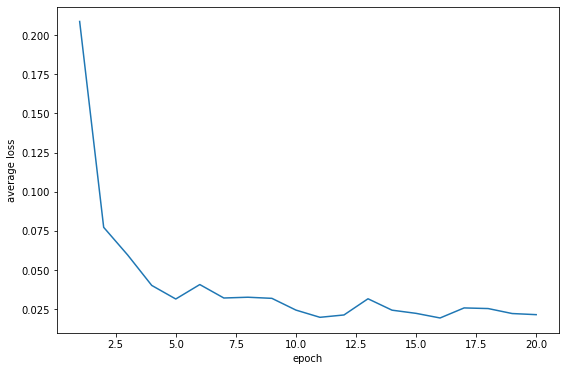


Accuracy for each classes: 
	0 :  98.89%
	1 :  99.39%
	2 :  99.03%
	3 :  99.11%
	4 :  99.39%
	5 :  98.77%
	6 :  99.27%
	7 :  99.22%
	8 :  99.18%
	9 :  99.40%

Confusion Matrix: 


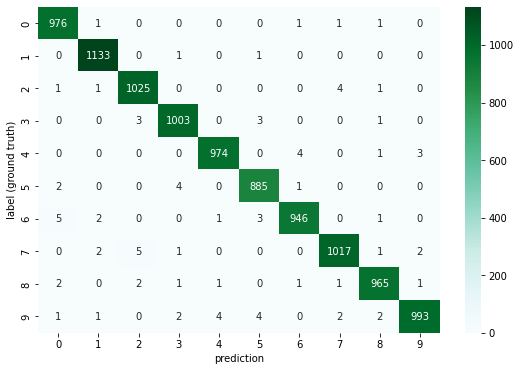

In [ ]:
#### MNIST
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args(args=[])
    
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    TrainingSet = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    TestSet = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(TrainingSet, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(TestSet, **test_kwargs)
    
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_loss = []
    for epoch in range(1, args.epochs + 1):
        y_pred = []
        y_true = []
        avg_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss.append(avg_loss)
        y_pred, y_true = test(model, device, test_loader, y_pred, y_true)
        scheduler.step()
        if epoch == args.epochs: # the last epoch
            plot_loss_curve(train_loss, args.epochs)
            plot_acc_and_confusion_matrix(y_true, y_pred, "MNIST")
    

if __name__ == '__main__':
    main()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.574233
Test set: Average loss: 0.3125, Accuracy: 8836/10000 (88%)

Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.353019
Test set: Average loss: 0.2520, Accuracy: 9077/10000 (91%)

Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.317823
Test set: Average loss: 0.2422, Accuracy: 9117/10000 (91%)

Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.198618
Test set: Average loss: 0.2308, Accuracy: 9184/10000 (92%)

Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.116149
Test set: Average loss: 0.2233, Accuracy: 9227/10000 (92%)

Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.269202
Test set: Average loss: 0.2144, Accuracy: 9237/10000 (92%)

Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.217879
Test set: Average loss: 0.2136, Accuracy: 9264/10000 (93%)

Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.126476
Test set: Average loss: 0.2158, Accuracy: 9246/10000 (92%)

Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.095442
Test set: Average loss: 0.2083, Accuracy: 9284/10000 (93%)

Train Epoc

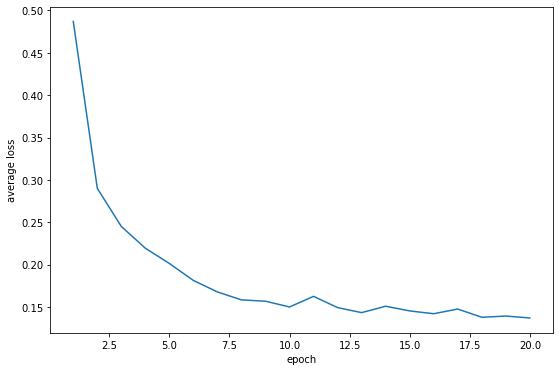


Accuracy for each classes: 
	T-shirt :  87.82%
	Trouser :  99.39%
	Pullover :  89.66%
	Dress :  91.95%
	Coat :  88.38%
	Sandal :  98.60%
	Shirt :  81.15%
	Sneaker :  96.17%
	Bag :  98.99%
	Ankle boot :  97.78%

Confusion Matrix: 


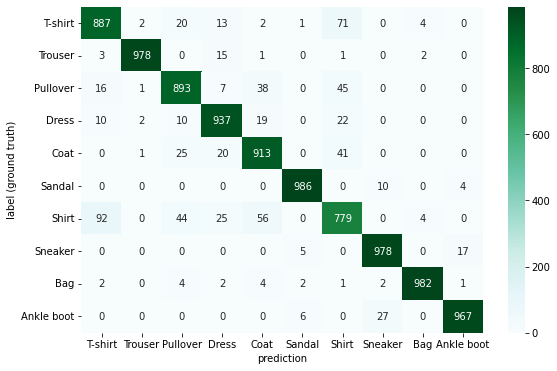

In [ ]:
#### FashionMNIST
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch FashionMNIST')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args(args=[])
    
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    TrainingSet = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    TestSet = datasets.FashionMNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(TrainingSet, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(TestSet, **test_kwargs)
    
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_loss = []
    for epoch in range(1, args.epochs + 1):
        y_pred = []
        y_true = []
        avg_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss.append(avg_loss)
        y_pred, y_true = test(model, device, test_loader, y_pred, y_true)
        scheduler.step()
        if epoch == args.epochs: # the last epoch
            plot_loss_curve(train_loss, args.epochs)
            plot_acc_and_confusion_matrix(y_true, y_pred, "FashionMNIST")
    

if __name__ == '__main__':
    main()

可以看出因為上半身衣服的形狀都蠻像的，所以準確率都偏低(e.g., T-shirt,Pullover, Coat, Shirt)

褲子因為形狀長得最不一樣所以最難分辨出來（準確率最高）

In [ ]:
#### CIFAR10
import torch.nn.init as init # for kaiming initialization

# initialize weights
def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = LambdaLayer(lambda x:
                                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._add_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._add_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._add_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        # if the layer is conv2d or linear layer use Kaiming initialization to initialize the weights
        self.apply(_weights_init)

    def _add_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # need log_softmax to make loss is positive if using nll_lose
        output = F.log_softmax(out, dim=1) # nll_loss + log_sofmax = cross_entropy
        return output


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch CIFAR10')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=50, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    args = parser.parse_args(args=[])
    
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    train_transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2012))
        ])
    
    test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2012))
        ])
    TrainingSet = datasets.CIFAR10('../data', train=True, download=True,
                       transform=train_transform)
    TestSet = datasets.CIFAR10('../data', train=False,
                       transform=test_transform)
    train_loader = torch.utils.data.DataLoader(TrainingSet, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(TestSet, **test_kwargs)
    
    model = resnet20().to(device)

    # optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    scheduler = StepLR(optimizer, step_size=10, gamma=args.gamma)

    train_loss = []
    for epoch in range(1, args.epochs + 1):
        y_pred = []
        y_true = []
        avg_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss.append(avg_loss)
        y_pred, y_true = test(model, device, test_loader, y_pred, y_true)
        scheduler.step()
        if epoch == args.epochs:
            plot_loss_curve(train_loss, args.epochs)
            plot_acc_and_confusion_matrix(y_true, y_pred, "CIFAR10")

if __name__ == '__main__':
    main()

Files already downloaded and verified
Train Epoch: 1 [49920/50000 (100%)]	Loss: 1.160158
Test set: Average loss: 1.1975, Accuracy: 5731/10000 (57%)

Train Epoch: 2 [49920/50000 (100%)]	Loss: 0.837831
Test set: Average loss: 1.1545, Accuracy: 6069/10000 (61%)

Train Epoch: 3 [49920/50000 (100%)]	Loss: 0.747022
Test set: Average loss: 0.8778, Accuracy: 7126/10000 (71%)

Train Epoch: 4 [49920/50000 (100%)]	Loss: 1.126999
Test set: Average loss: 0.8362, Accuracy: 7202/10000 (72%)

Train Epoch: 5 [49920/50000 (100%)]	Loss: 0.456976
Test set: Average loss: 0.6286, Accuracy: 7937/10000 (79%)

Train Epoch: 6 [49920/50000 (100%)]	Loss: 0.426323
Test set: Average loss: 0.6379, Accuracy: 7824/10000 (78%)

Train Epoch: 7 [49920/50000 (100%)]	Loss: 0.337709
Test set: Average loss: 0.5718, Accuracy: 8065/10000 (81%)

Train Epoch: 8 [49920/50000 (100%)]	Loss: 0.383117
Test set: Average loss: 0.5508, Accuracy: 8127/10000 (81%)

Train Epoch: 9 [49920/50000 (100%)]	Loss: 0.387838
Test set: Average loss:

# **CIFAR10 Acc comparison for 30 epochs**


1.   **Optimizer**:
    - Adadelta: acc = 63%
 - Adam: acc = 76%
  - SGD: acc = 80%


2.   **Image Transformation**:

    [參考論文](https://arxiv.org/pdf/1512.03385.pdf)

    ```
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    ```
    acc:  80%  >>  84%
3. **Scheduler step size**:
 - Step size = 1, acc = 84%
  - Step size = 2, acc = 87%
  - Step size = 3, acc = 88%
  - Step size = 4, acc = 88%
  - Step size = 10, acc = 88%

用step size = 10, 跑50個epochs可以有 **89%** 的準確率



# **What I learn ?**

1. ResNet架構

2. 可以畫出訓練時的loss function來確認模型是否有在學習

3. Image transformation參數弄對很有用

4. 調整scheduler step size可以加快模型訓練




